In [1]:
%cd /mnt/c/Users/BarbarianMatt/Code/Python/EE595ProjectAI/ns-3-dev/contrib/ai/examples/a-plus-b/use-msg-stru
import ns3ai_apb_py_stru as py_binding
from ns3ai_utils import Experiment
import sys
import traceback
import uuid
import time
import subprocess
import numpy as np

import gc
from multiprocessing import Process
import os

from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

!rm /dev/shm/*

/mnt/c/Users/BarbarianMatt/Code/Python/EE595ProjectAI/ns-3-dev/contrib/ai/examples/a-plus-b/use-msg-stru


In [2]:
    # msgInterface.PyRecvBegin()
    # temp = msgInterface.GetCpp2PyStruct()
    # C=temp.mldThptTotal
    # print(C)
    # msgInterface.PyRecvEnd()

    # msgInterface.PySendBegin()
    # msgInterface.GetPy2CppStruct().c = 2
    # msgInterface.PySendEnd()

    # msgInterface.PyRecvBegin()
    # temp = msgInterface.GetCpp2PyStruct()
    # C=temp.mldThptTotal
    # print(C)
    # msgInterface.PyRecvEnd()

    # for j in np.arange(1):
    #     print("Starting experiment...", flush=True)
    #     msgInterface = exp.run(setting=setting, show_output=True)
    #     print("Experiment started.", flush=True)
    #     start_time = time.time()
    #     try:
    #         for i in range(1000):
                
                
    #             msgInterface.PyRecvBegin()


    #             if msgInterface.PyGetFinished() or time.time() - start_time > 20:
    #                 break


    #             # print(f"Received a: {msgInterface.GetCpp2PyStruct().a}, b: {msgInterface.GetCpp2PyStruct().b}")

    #             temp = msgInterface.GetCpp2PyStruct().a + msgInterface.GetCpp2PyStruct().b
    #             msgInterface.PyRecvEnd()

    #             msgInterface.PySendBegin()
    #             msgInterface.GetPy2CppStruct().c = temp
    #             msgInterface.PySendEnd()

    #             # print('', flush=True)
    #             # print(i, flush=True)

    #     except Exception as e:
    #         exc_type, exc_value, exc_traceback = sys.exc_info()
    #         print("Exception occurred: {}".format(e), flush=True)
    #         print("Traceback:", flush=True)
    #         traceback.print_tb(exc_traceback)
    #         exit(1)
    #     finally:
    #         print("Finally exiting...", flush=True)

    #     # del exp
    #     del msgInterface
    #     gc.collect()
    #     # subprocess.run(['rm', '-f', f'/dev/shm/My_Seg_{unique_id}'])
    #     # time.sleep(5)


In [3]:
values_we_care_about = ['mldThptTotal', 'acBECwminLink1','acBECwminLink2', 'mldProbLink1']
# values_we_care_about = ['mldThptTotal', 'mldProbLink1']


def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    
def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()

SMALL_NUMBER=float('-inf')
INPUT_DIM=len(values_we_care_about)+1
HIDDEN_DIM=64

OUTPUT_DIM=4
class DQN(nn.Module):
    def __init__(self, INPUT_DIM, HIDDEN_DIM,OUTPUT_DIM):
        super(DQN, self).__init__()
        self.input = nn.Linear(INPUT_DIM, HIDDEN_DIM)
        self.fc1 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.fc3 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.fc4 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        # self.fc5 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        # self.fc6 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        # self.fc7 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        # self.fc8 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        # self.fc9 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.move_piece = nn.Linear(HIDDEN_DIM, OUTPUT_DIM)

        A=0.07
        self.dropout = nn.Dropout(A)
        self.dropout1 = nn.Dropout(A)
        self.dropout2 = nn.Dropout(A)




    
    def forward(self, y, mask,valid_moves_tensor):
    
       
        x = torch.relu(self.input(y))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc4(x))
        # x = torch.relu(self.fc5(x))
        # x = torch.relu(self.fc6(x))
        # x = torch.relu(self.fc7(x))
        # x = torch.relu(self.fc8(x))
        # x = torch.relu(self.fc9(x))
        

        move_piece = self.move_piece(x)

        if mask:
            # mask_tensor = torch.full_like(move_piece, 0)
            mask_tensor = torch.full_like(move_piece, SMALL_NUMBER)
            mask_tensor[valid_moves_tensor.bool()] = 0

            move_piece += mask_tensor
        return move_piece

In [4]:
!rm /dev/shm/*


def dton(state):
    state_current = state['current_state']
    ar1=np.array([0 if (key in state_current and (state_current[key] is None or np.isnan(state_current[key]))) else state_current[key] 
          for key in values_we_care_about if key in state_current])


    state_previous = state['previous_state']
    ar2=np.array([0 if (key in state_previous and (state_previous[key] is None or np.isnan(state_previous[key]))) else state_previous[key] 
          for key in ['mldProbLink1'] if key in state_previous])
    if len(ar2) == 0:
        ar2 = np.zeros(1)
    # state_previous = state['previous_state']
    # ar2=np.array([0 if (key in state_previous and (state_previous[key] is None or np.isnan(state_previous[key]))) else state_previous[key] 
    #       for key in values_we_care_about if key in state_previous])
    # if len(ar2) < len(ar1):
    #     ar2 = np.zeros(len(ar1))
    # ar2=np.array([])

    return np.concatenate((ar1,ar2))
def convert(state):
    return torch.FloatTensor(state.flatten()).unsqueeze(0)

def move_nn_to_adjustments(move_nn, state, obj):


    if move_nn == 0:
        obj.cwStep1 -= 0.5
        current_acBECwminLink1 = int(np.ceil(2**obj.cwStep1))

        obj.cwStep2 -= 0.5
        current_acBECwminLink2 = int(np.ceil(2**obj.cwStep2))


    elif move_nn == 1:
        obj.cwStep1 += 0.5
        current_acBECwminLink1 = int(np.ceil(2**obj.cwStep1))

        obj.cwStep2 -= 0.5
        current_acBECwminLink2 = int(np.ceil(2**obj.cwStep2))
    
    elif move_nn == 2:
        obj.cwStep1 -= 0.5
        current_acBECwminLink1 = int(np.ceil(2**obj.cwStep1))

        obj.cwStep2 += 0.5
        current_acBECwminLink2 = int(np.ceil(2**obj.cwStep2))


    elif move_nn == 3:
        obj.cwStep1 += 0.5
        current_acBECwminLink1 = int(np.ceil(2**obj.cwStep1))

        obj.cwStep2 += 0.5
        current_acBECwminLink2 = int(np.ceil(2**obj.cwStep2))

    adjustments= {
        'acBECwminLink1' : current_acBECwminLink1,
        'acBECwminLink2' : current_acBECwminLink2,
    }

    return adjustments

class SimpleAgent:
    def __init__(self, filepath):
        self.dqn=DQN(INPUT_DIM, HIDDEN_DIM,OUTPUT_DIM)
        self.dqn.load_state_dict(torch.load(filepath))
        self.type = 'DQN'

    def decide(self, state, valid_moves):

        self.dqn.eval()
        state_c=convert(dton(state))
        valid_moves_c=convert(valid_moves)
        with torch.no_grad():
            # move_piece_q  = self.dqn(state,True,convert(self.game.vector_valid_moves(self.unique_id)))
            move_piece_q  = self.dqn(state_c,True, valid_moves_c)
            num_moves_choices=1
            move_nn=torch.argsort(move_piece_q[0], descending=True)[np.random.choice(num_moves_choices)].item()

            return [move_nn]

class Environnment:
    def __init__(self, step_size = 10, max_steps=100, mldPerNodeLambda=1e-5):

        self.step_size = step_size
        self.max_steps=max_steps
        self.mldPerNodeLambda= mldPerNodeLambda
        self.done_simulation=False
        self.end_experiment = False

        self.experiments=-1

        first_segment = np.linspace(0.5, 1, self.max_steps // 3, endpoint=False)
        second_segment = np.linspace(1, 0, self.max_steps-len(first_segment), endpoint=False)
        self.path1 = np.round(np.concatenate([first_segment, second_segment]),decimals=4)

        first_segment = np.linspace(0.5, 0, self.max_steps // 3, endpoint=False)
        second_segment = np.linspace(0, 1, self.max_steps-len(first_segment), endpoint=False)
        self.path2 = np.round(np.concatenate([first_segment, second_segment]),decimals=4)


        first_segment = np.ones(self.max_steps)
        self.path3 = np.round(first_segment, decimals=4)

        self.unique_id = str(uuid.uuid4())

        self.filepath = '/mnt/c/Users/BarbarianMatt/Code/Python/EE595ProjectAI/ns-3-dev'

        setting = { "num_env": 1, 
                    "m_segmentName":f"My_Seg_{self.unique_id}",
                    "m_cpp2pyMsgName":f"My_Cpp_to_Python_Msg_{self.unique_id}",
                    "m_py2cppMsgName":f"My_Python_to_Cpp_Msg_{self.unique_id}",
                    "m_lockableName":f"My_Lockable_{self.unique_id}"
                    }

        self.exp = Experiment(
            "ns3ai_apb_msg_stru",
            self.filepath,
            py_binding,
            handleFinish=True,
            segName=setting['m_segmentName'],
            cpp2pyMsgName=setting['m_cpp2pyMsgName'],
            py2cppMsgName=setting['m_py2cppMsgName'],
            lockableName=setting['m_lockableName']
        )

        result = subprocess.run(['ls', '/dev/shm'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

        # Print the output (list of shared memory segments)
        if result.returncode == 0:
            print("Shared memory segments:")
            print(result.stdout)
        else:
            print(f"Error: {result.stderr}")

        print("Starting experiment...", flush=True)
        self.msgInterface = self.exp.run(setting=setting, show_output=True)
        print("Experiment started.", flush=True)

        self.reset()


    def sendReceive(self):
        self.msgInterface.PySendBegin()
        msg = self.msgInterface.GetPy2CppStruct()
        msg.done_simulation = self.done_simulation
        msg.end_experiment = self.end_experiment
        for key in self.parameters:
            if key != 'mldProbLink1':
                val = self.parameters[key]
            else:
                val = self.path[self.num_steps] if self.num_steps< len(self.path) else self.path[-1]
                self.parameters[key] = val
            setattr(msg, key, val)

        self.msgInterface.PySendEnd()

        self.msgInterface.PyRecvBegin()
        self.state_cc = self.msgInterface.GetCpp2PyStruct()
        self.msgInterface.PyRecvEnd()
        self.update_state()

        # print(f'Test: {self.state_cc.simulationTime}')

    def update_state(self):
        # Save the current state as previous_state before updating the state
        self.previous_state = self.state.copy() if hasattr(self, 'state') else {}

        # Update the current state based on the new values from state_cc
        d = dir(self.state_cc)
        state = {}
        for attribute in d:
            if not attribute[:2] == '__':
                state[attribute] = getattr(self.state_cc, attribute)
        self.state = state


    def reset(self):

        self.parameters = {
            'acBECwminLink1': 16,
            'acBECwminLink2': 16,
            'acBECwStageLink1': 6,
            'simulationTime': self.step_size,
            'mldPerNodeLambda': self.mldPerNodeLambda,
            'totalSteps': self.max_steps,
            'mldProbLink1': 0.5,
        }

        paths = [self.path1, self.path2, self.path3]
        self.path = paths[self.experiments % len(paths)]
        if self.experiments % len(paths)==2:
            self.path = self.path*np.random.rand()

        self.cwStep1=4
        self.cwStep2=4

        self.num_steps=0

        self.done_simulation=True 
        self.step()
        self.done_simulation=False

        self.experiments+=1

        return self.get_state()


    def step(self):
        # if self.num_steps>= self.max_steps:
        #     self.done_simulation=True
        self.sendReceive()
        self.num_steps +=1
        

    
    def get_state(self):
        # Return both the current state and the previous state
        return {'current_state': self.state, 'previous_state': self.previous_state}
    
    def update_environment(self, move_nn):

        action = move_nn_to_adjustments(move_nn, self.get_state(), self)

        # # # print('action: ', action)

        for key in action:
            adjustment = action[key]
            self.parameters[key]=adjustment

        # print('parameters: ', self.parameters)
        # print(f'{self.state["stepNumber"]}-{self.experiments}', end=" ")
        print(f'{self.state["stepNumber"]}', end=" ")
        
        self.step()

        reward = self.calc_reward()

        
        done = self.num_steps>self.max_steps

        return self.get_state(), reward, done



    def calc_reward(self):
        reward = self.state['mldThptTotal']
        return reward

    def get_valid_moves(self):
        valid_moves = np.array([1,1,1,1])

        if self.state['acBECwminLink1'] <=1:
            valid_moves[0]=0
            valid_moves[2]=0
        
        elif self.state['acBECwminLink1'] >=1e7:
            valid_moves[1]=0
            valid_moves[3]=0

        if self.state['acBECwminLink2'] <=1:
            valid_moves[0]=0
            valid_moves[1]=0
        
        elif self.state['acBECwminLink2'] >=1e7:
            valid_moves[2]=0
            valid_moves[3]=0


        return valid_moves
    def end(self):
        self.end_experiment=True 
        self.sendReceive()
        self.end_experiment=False

def run():
    x = Environnment(mldPerNodeLambda=0.01, step_size=0.1)
    try:
        i = 0
        x.parameters['acBECwminLink1']=16
        # x.parameters['acBECwStageLink1']=2
        # print(x.get_state()['mldThptTotal'], i, flush=True)
        for i in np.arange(1, 16):
            # x.step()
            x.update_environment(3)
            # x.step()
            # print(x.get_state()['mldThptTotal'], i, flush=True)
            print(dton(x.get_state()))
            # x.reset()
            # print(x.get_state()['mldThptTotal'], i, flush=True)
        
        # x.step()
        # # x.parameters['acBECwminLink1'] = 32
        # print(x.get_state()['mldThptTotal'])
        # x.step()
        # print(x.get_state()['mldThptTotal'])
        # x.step()
        # print(x.get_state()['mldThptTotal'])
        # x.step()
        # print(x.get_state()['mldThptTotal'])
        # x.step()
        # print(x.get_state()['mldThptTotal'])
        # x.step()
        # print(x.get_state()['mldThptTotal'])
        # x.step()
        # print(x.get_state()['mldThptTotal'])

    finally:
        x.end()


# process = Process(target=run)
# process.start()
# process.join()
# del process

rm: cannot remove '/dev/shm/*': No such file or directory


In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.size=len(self.buffer)
    def push(self, *args):
        self.buffer.append(args)
        self.size=len(self.buffer)
    # random sampling
    def sample(self, batch_size):
        batch_size = min(batch_size, len(self.buffer))
        indices = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        samples=[self.buffer[i] for i in indices]
        self.buffer = deque([self.buffer[i] for i in range(len(self.buffer)) if i not in indices], maxlen=self.capacity)
        # samples = [self.buffer.popleft() for _ in range(batch_size)]
        self.size=len(self.buffer)
        return samples

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done', 'valid_moves', 'next_valid_moves'))

def train_dqn(env, dqn, target_dqn, episodes=1000, batch_size=64, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01,lr_start=1e-4, lr_end=1e-4, eval_every=100, games_per_eval=100):
    episodes=int(episodes)
    optimizer = optim.Adam(dqn.parameters(), lr_start)
    loss_fn = nn.MSELoss()
    lr_decay= (lr_end / lr_start) ** (1 / episodes)
    scheduler = StepLR(optimizer, step_size=1, gamma=lr_decay)

    epsilon = epsilon_start
    epsilon_decay = (epsilon_end / epsilon_start) ** (1 / (0.98*episodes))
    optimizer.optimizations=0
    optimizer.optimizations_cyclic=0

    replay_buffer=ReplayBuffer(3*batch_size)

    total_rewards_list=[]

    # filepath='./dqn_new_model.pth'
    # load_model(dqn, filepath)
    # load_model(target_dqn, filepath)

    # print("correct one good job")
    def optimize_model(replay_buffer, model, target_model,optimizer):
        total_loss=0
        model.train()
        if True:
        # while replay_buffer.size >= batch_size:
            optimizer.optimizations+=1
            optimizer.optimizations_cyclic+=batch_size
            transitions = replay_buffer.sample(batch_size) # state, move, reward, resulting_state, done, repeat
            batch = Transition(*zip(*transitions)) # seperates into a more usable structure

            # print('batch: ',batch)
            # print(batch.action)

            # seperate batch into variables
            state_batch = torch.cat(batch.state)
            action_batch = torch.tensor(batch.action, dtype=torch.int64) #change to int8
            reward_batch = torch.tensor(batch.reward, dtype=torch.float32)
            next_state_batch = torch.cat(batch.next_state)
            done_batch = torch.tensor(batch.done, dtype=torch.float32)
            valid_moves_batch = torch.cat(batch.valid_moves)
            next_valid_moves_batch = torch.cat(batch.next_valid_moves)
            # print(next_state_batch[0])
            # print(next_state_batch[1])
            # print()
            

            q_values = model(state_batch,True, valid_moves_batch) # the models responses to different states, masked for legality
            state_action_values = q_values.gather(1, action_batch.view(-1, 1)).squeeze() # q_values of the actions it actually took

            next_q_values = model(next_state_batch, True,next_valid_moves_batch) # the models responses to the resulting states as the next player
            next_actions = next_q_values.max(1)[1] # what that player likely would have done
            next_target_q_values = target_model(next_state_batch, True,next_valid_moves_batch) # target model which is updated less frequently for stability
            next_state_values = next_target_q_values.gather(1, next_actions.unsqueeze(1)).squeeze() # q_values of the other player likely to result from your actions
            
            # print('reward batch: ',reward_batch)
            # print('action batch: ',action_batch.view(-1, 1))
            # print('next_actions: ',next_actions)
            # print('state batch: ',state_batch)
            # print('next state batch: ',next_state_batch)
            # print('state_action_values: ',state_action_values)
            # print('q_values',q_values)
            # print('next_target_q_values',next_target_q_values)
            # print('next_state_values',next_state_values)
            # print('done batch',done_batch)
            # print('valid_moves batch',valid_moves_batch)
            # print('newt_valid_moves batch',next_valid_moves_batch)

            expected_state_action_values = reward_batch + gamma * (next_state_values * (1 - done_batch)) # what the reward is from your actions

            # print(expected_state_action_values)

            # for param in model.parameters():
            #     if param.grad is not None:
            #         print(param.grad.norm().item())

            # nn.utils.clip_grad_norm_(model.parameters(), 10)

            # for param in model.parameters():
            #     if param.grad is not None:
            #         print(param.grad.norm().item())
            
            base_loss =loss_fn(state_action_values, expected_state_action_values)

            # wild_jack_mask = (action_batch >= 96) & (action_batch < 192)  # Identify wild jack moves
            # proper_use_mask = reward_batch > 0  # Identify moves that resulted in a positive reward

            # # If the wild jack was used but no positive reward was obtained, increase the loss
            # wild_jack_loss_weight = torch.ones_like(base_loss)  # Initialize loss weights to 1 (no change)
            # wild_jack_loss_weight[wild_jack_mask & ~proper_use_mask] = 1.5  # Increase loss for wasted wild jacks
            # wild_jack_loss_weight[wild_jack_mask & proper_use_mask] = 0.8   # Decrease loss for good use of wild jacks

            # # Apply weighted loss
            # loss = base_loss * wild_jack_loss_weight
            loss= base_loss

            optimizer.zero_grad()
            loss.backward()
            # nn.utils.clip_grad_norm_(model.parameters(), 1)
            # for param in model.parameters():
            #     if param.grad is not None:
            #         print(param.grad.norm().item())
            optimizer.step()
            total_loss+=loss.item()
        
        return total_loss
    
    def select_epsilon_greedy_action(env, model, state, epsilon, valid_moves):
        rand=np.random.rand()
        # print('state: ', state, state.shape)
        if rand<epsilon:

            valid=np.where(valid_moves.numpy()[0]==1)[0]

            move =np.random.choice(valid)
            return [move]

        else:
            with torch.no_grad():
                # print('Choose Move')
                model.eval()
                q_values = model(state,True, valid_moves)
                # print('After Choose Move')
                # print('valid_moves: ',q_values[0].cpu().numpy())
                # print('valid_moves: ',np.isfinite(q_values[0].cpu().numpy()))
                valid_num_moves=np.sum(np.array(np.isfinite(q_values[0].cpu().numpy())))
                moves_to_pick_from=min(valid_num_moves,1)


                if moves_to_pick_from > 0:
                    return [torch.argsort(q, descending=True)[np.random.choice(moves_to_pick_from)].item() for q in q_values]
                else:
                    print(state)
                    print("Error No Valid Moves", flush=True)
                    return []
    
    total_losses = 0

    for episode in range(episodes):
        # print('episode: ', episode, flush=True)
        state = convert(dton(env.reset()))
        # print('Hello', flush=True)
        valid_moves = convert(env.get_valid_moves())
        total_rewards = 0
        episode_q_values = []
        done = False
        moves=0
        
        while not done:
            # print('Move Number: ', moves)
            if sum(valid_moves[0])>0:
                # print('Select Move')
                action = select_epsilon_greedy_action(env, dqn, state, epsilon,valid_moves)
                # print('Before Update')
                next_state, reward, done = env.update_environment(action[0])
                # print('After Update')
                if episodes-episode<=2:
                # if True:

                    np.set_printoptions(formatter={'all': lambda x: f' {x}'},suppress=True)

                    # Example usage with your variables
                    print(np.array(action), 
                        np.array2string(np.round(np.array(dton(next_state)), decimals=4), separator=','), 
                        np.round(reward, decimals=4), 
                        done)
                next_state=convert(dton(next_state))
                next_valid_moves=convert(env.get_valid_moves())
                if not done and sum(next_valid_moves[0])>0:
                    replay_buffer.push(state, action, reward, next_state, done, valid_moves,next_valid_moves)
                else:
                    replay_buffer.push(state, action, reward, state, True, valid_moves,valid_moves)
                    done=True
                state = next_state
                valid_moves=next_valid_moves
                total_rewards+=reward
                # print('total_rewards: ',total_rewards)
                moves+=1
            else:
                print('no valid moves backup procedure', flush=True)
                print(state)
                state,action,reward,next_state,done,valid_moves,next_valid_moves=replay_buffer.buffer.popleft()
                replay_buffer.push(state, action, 0, state, True, valid_moves,valid_moves)
                done=True
            # print('End of Move')
        print("", flush=True)  
        # print('Hello 2!', flush=True)
        losses = optimize_model(replay_buffer, dqn, target_dqn, optimizer)
        # print('losses: ', losses)
        if losses > 0:
            total_losses = losses


        scheduler.step()
        current_lr=scheduler.get_last_lr()[0]
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        model_filepath="/mnt/c/Users/BarbarianMatt/Code/Python/EE595ProjectAI/ns-3-dev/contrib/ai/examples/a-plus-b/use-msg-stru/dqn_new_model.pth"
        if episode % (max(episodes//10,1)) == 0 and episode>max(episodes//10,1):
            print("saved over!", flush=True)
            save_model(dqn, model_filepath)
        
        if optimizer.optimizations_cyclic > 1:
            # print('target dqn updated')
            target_dqn.load_state_dict(dqn.state_dict())
            optimizer.optimizations_cyclic=0
        
        strin=f'Episode {episode + 1}/{episodes}, Epsilon: {epsilon:.3f}, Lr: {current_lr:.3e} '

        strin+= f'Rewards: {total_rewards:.4f}, Losses: {total_losses:.3f}, '
       
        strin+=f'Total Moves: {moves}, '
        strin+=f'Total Optimizations: {optimizer.optimizations}'
        
        print(strin, flush=True)

        total_rewards_list.append(total_rewards)

    # env.end()
    print("Training complete, saving final model.", flush=True)
    save_model(dqn, model_filepath)



    return total_rewards_list

In [6]:
!rm /dev/shm/*
np.random.seed(25)

def run_ai():
    env=Environnment(step_size=0.1,max_steps=60, mldPerNodeLambda=0.1)
    try:

        dqn = DQN(INPUT_DIM, HIDDEN_DIM,OUTPUT_DIM)
        dqn_target = DQN(INPUT_DIM, HIDDEN_DIM,OUTPUT_DIM)
 

        _=total_reward_lists=train_dqn(env, dqn, dqn_target, episodes=20, batch_size=60*8, gamma=0.999, epsilon_start=1, epsilon_end=0.05, lr_start=1e-2, lr_end=1e-4)

        print('Awesome2')
        # env.end()
        # del env
        print('Awesome')
    finally:
        env.end()
        # del env
        print('Awesome3')

process = Process(target=run_ai)
process.start()
process.join()

rm: cannot remove '/dev/shm/*': No such file or directory
Experiment Created!
ns3ai_utils: Experiment initialized
Shared memory segments:
My_Seg_86c49afc-03e3-424c-bfaf-6481c2a70169

Starting experiment...
Experiment started.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 
Episode 1/20, Epsilon: 0.858, Lr: 7.943e-03 Rewards: 14.9880, Losses: 0.292, Total Moves: 60, Total Optimizations: 1
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 
Episode 2/20, Epsilon: 0.737, Lr: 6.310e-03 Rewards: 13.1900, Losses: 2.099, Total Moves: 60, Total Optimizations: 2
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 
Episode 3/20, Epsilon: 0

rm: cannot remove '/dev/shm/*': No such file or directory
Experiment Created!
ns3ai_utils: Experiment initialized
Shared memory segments:
My_Seg_33b1aeb0-2089-45c0-9f16-a75b71aa77d5

Starting experiment...
Experiment started.


/tmp/ipykernel_710691/912328698.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.dqn.load_state_dict(torch.load(filepath))


1 [ 1] [ 0.0, 23.0, 12.0, 0.8701, 0.8701] 0.0 False
2 [ 1] [ 0.0, 32.0, 8.0, 0.8701, 0.8701] 0.0 False
3 [ 1] [ 0.0, 46.0, 6.0, 0.8701, 0.8701] 0.0 False
4 [ 1] [ 0.0, 64.0, 4.0, 0.8701, 0.8701] 0.0 False
5 [ 1] [ 0.0, 91.0, 3.0, 0.8701, 0.8701] 0.0 False
6 [ 1] [ 0.0, 128.0, 2.0, 0.8701, 0.8701] 0.0 False
7 [ 1] [ 0.668, 182.0, 2.0, 0.8701, 0.8701] 0.668 False
8 [ 1] [ 0.24, 256.0, 1.0, 0.8701, 0.8701] 0.24 False
9 [ 2] [ 0.134, 182.0, 2.0, 0.8701, 0.8701] 0.134 False
10 [ 1] [ 0.138, 256.0, 1.0, 0.8701, 0.8701] 0.138 False
11 [ 2] [ 0.136, 182.0, 2.0, 0.8701, 0.8701] 0.136 False
12 [ 1] [ 0.132, 256.0, 1.0, 0.8701, 0.8701] 0.132 False
13 [ 2] [ 0.158, 182.0, 2.0, 0.8701, 0.8701] 0.158 False
14 [ 1] [ 0.144, 256.0, 1.0, 0.8701, 0.8701] 0.144 False
15 [ 2] [ 0.118, 182.0, 2.0, 0.8701, 0.8701] 0.118 False
16 [ 1] [ 0.148, 256.0, 1.0, 0.8701, 0.8701] 0.148 False
17 [ 2] [ 0.146, 182.0, 2.0, 0.8701, 0.8701] 0.146 False
18 [ 1] [ 0.154, 256.0, 1.0, 0.8701, 0.8701] 0.154 False
19 [ 2] [ 0.1

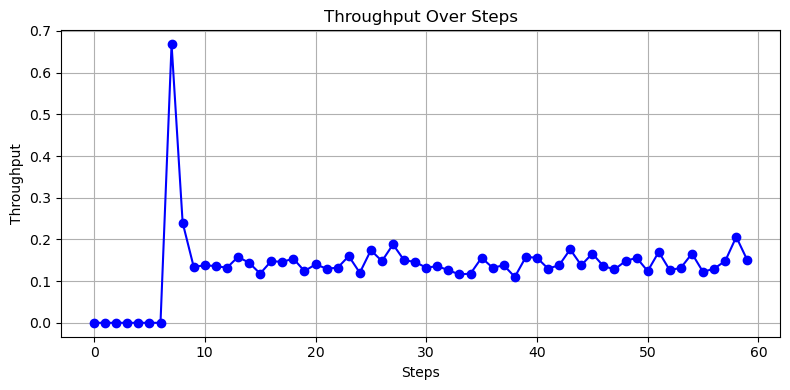

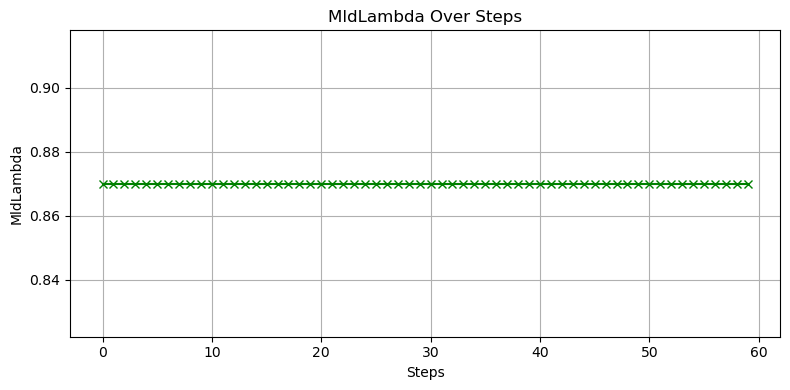

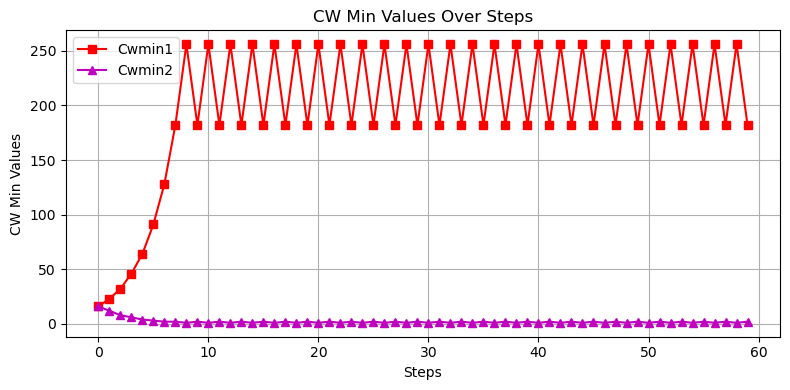

TOTAL THROUGHPUT: 8.196
1 [ 1] [ 0.0, 23.0, 12.0, 0.525, 0.5] 0.0 False
2 [ 1] [ 0.0, 32.0, 8.0, 0.55, 0.525] 0.0 False
3 [ 1] [ 0.0, 46.0, 6.0, 0.575, 0.55] 0.0 False
4 [ 1] [ 0.0, 64.0, 4.0, 0.6, 0.575] 0.0 False
5 [ 1] [ 0.0, 91.0, 3.0, 0.625, 0.6] 0.0 False
6 [ 1] [ 0.0, 128.0, 2.0, 0.65, 0.625] 0.0 False
7 [ 1] [ 0.852, 182.0, 2.0, 0.675, 0.65] 0.852 False
8 [ 1] [ 0.836, 256.0, 1.0, 0.7, 0.675] 0.836 False
9 [ 2] [ 0.314, 182.0, 2.0, 0.725, 0.7] 0.314 False
10 [ 1] [ 0.302, 256.0, 1.0, 0.75, 0.725] 0.302 False
11 [ 2] [ 0.27, 182.0, 2.0, 0.775, 0.75] 0.27 False
12 [ 1] [ 0.244, 256.0, 1.0, 0.8, 0.775] 0.244 False
13 [ 2] [ 0.214, 182.0, 2.0, 0.825, 0.8] 0.214 False
14 [ 1] [ 0.158, 256.0, 1.0, 0.85, 0.825] 0.158 False
15 [ 2] [ 0.118, 182.0, 2.0, 0.875, 0.85] 0.118 False
16 [ 1] [ 0.112, 256.0, 1.0, 0.9, 0.875] 0.112 False
17 [ 2] [ 0.092, 182.0, 2.0, 0.925, 0.9] 0.092 False
18 [ 1] [ 0.046, 256.0, 1.0, 0.95, 0.925] 0.046 False
19 [ 2] [ 0.016, 182.0, 2.0, 0.975, 0.95] 0.016 Fals

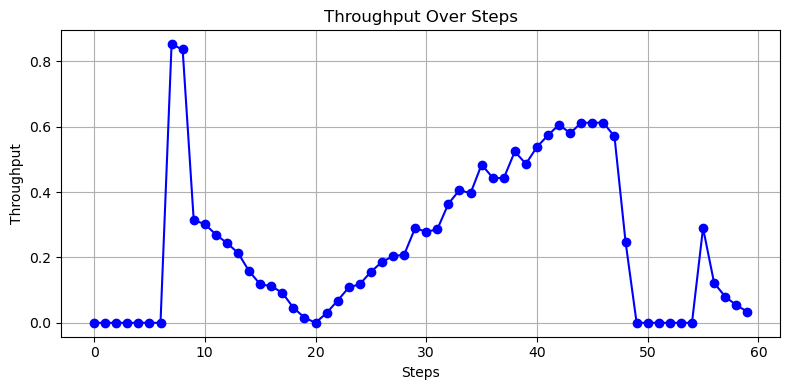

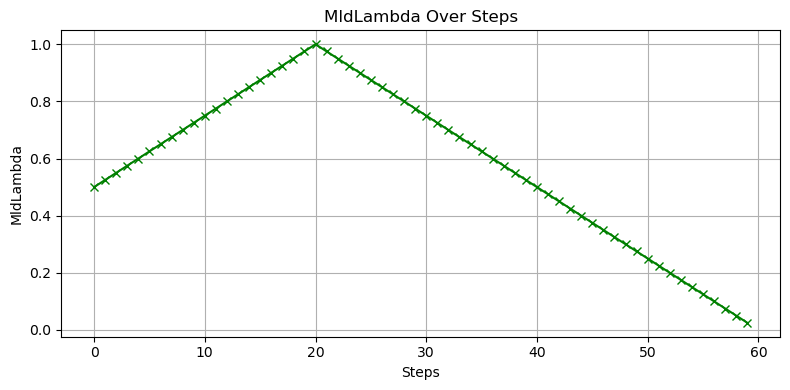

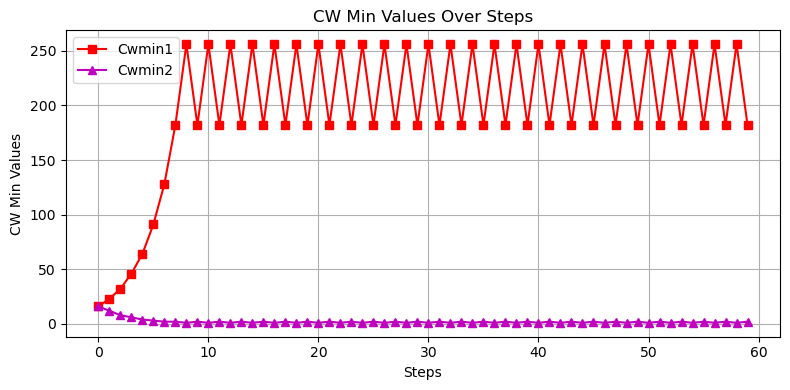

TOTAL THROUGHPUT: 14.584000000000001
1 [ 1] [ 0.0, 23.0, 12.0, 0.475, 0.5] 0.0 False
2 [ 1] [ 0.0, 32.0, 8.0, 0.45, 0.475] 0.0 False
3 [ 1] [ 0.0, 46.0, 6.0, 0.425, 0.45] 0.0 False
4 [ 1] [ 0.0, 64.0, 4.0, 0.4, 0.425] 0.0 False
5 [ 1] [ 0.0, 91.0, 3.0, 0.375, 0.4] 0.0 False
6 [ 1] [ 0.0, 128.0, 2.0, 0.35, 0.375] 0.0 False
7 [ 1] [ 0.962, 182.0, 2.0, 0.325, 0.35] 0.962 False
8 [ 1] [ 0.966, 256.0, 1.0, 0.3, 0.325] 0.966 False
9 [ 2] [ 0.892, 182.0, 2.0, 0.275, 0.3] 0.892 False
10 [ 1] [ 0.432, 256.0, 1.0, 0.25, 0.275] 0.432 False
11 [ 2] [ 0.238, 182.0, 2.0, 0.225, 0.25] 0.238 False
12 [ 1] [ 0.198, 256.0, 1.0, 0.2, 0.225] 0.198 False
13 [ 2] [ 0.216, 182.0, 2.0, 0.175, 0.2] 0.216 False
14 [ 1] [ 0.134, 256.0, 1.0, 0.15, 0.175] 0.134 False
15 [ 2] [ 0.132, 182.0, 2.0, 0.125, 0.15] 0.132 False
16 [ 1] [ 0.116, 256.0, 1.0, 0.1, 0.125] 0.116 False
17 [ 2] [ 0.066, 182.0, 2.0, 0.075, 0.1] 0.066 False
18 [ 1] [ 0.056, 256.0, 1.0, 0.05, 0.075] 0.056 False
19 [ 2] [ 0.034, 182.0, 2.0, 0.025, 0

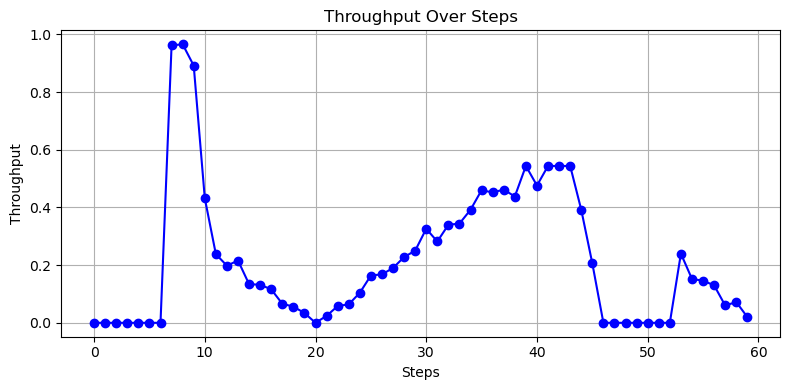

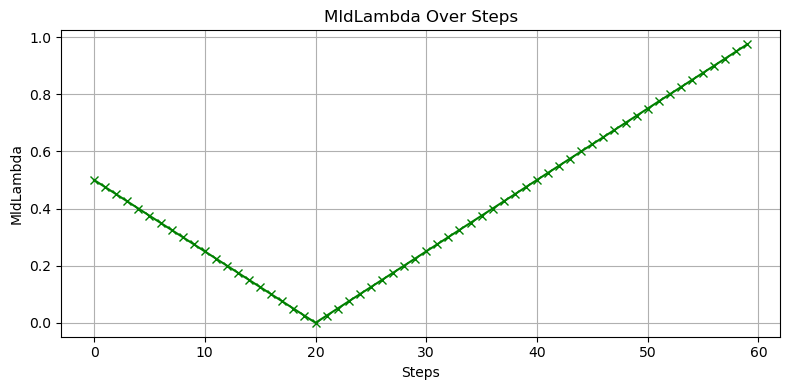

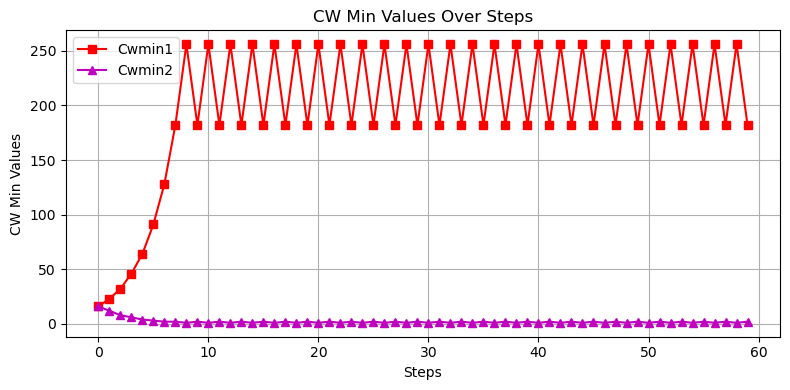

TOTAL THROUGHPUT: 13.258
ns3ai_utils: Killing subprocesses....
ns3ai_utils: Experiment destroyed


In [7]:
!rm /dev/shm/*
np.random.seed(25)

def run_ai2():
    env=Environnment(step_size=0.1,max_steps=60, mldPerNodeLambda=0.1)
    model_filepath="/mnt/c/Users/BarbarianMatt/Code/Python/EE595ProjectAI/ns-3-dev/contrib/ai/examples/a-plus-b/use-msg-stru/dqn_new_model.pth"
    agent = SimpleAgent(model_filepath)

    for loop in np.arange(3):


        throughput=[]
        mldlambda=[]
        cwmin1=[]
        cwmin2=[]

        done = False
        moves=0
        while not done:
            state = env.get_state()
            state_c = dton(state)
            action = agent.decide(state, env.get_valid_moves())
            next_state, reward, done = env.update_environment(action[0])
            

            np.set_printoptions(formatter={'all': lambda x: f' {x}'},suppress=True)

            # Example usage with your variables
            print(np.array(action), 
                np.array2string(np.round(np.array(dton(next_state)), decimals=4), separator=','), 
                np.round(reward, decimals=4), 
                done)

            throughput.append(state_c[0])
            mldlambda.append(state_c[3])

            cwmin1.append(state_c[1])
            cwmin2.append(state_c[2])

        
        print("", flush=True)


        steps = range(len(throughput))  # This assumes all lists are of the same length

        # Plot throughput on its own figure
        plt.figure(figsize=(8, 4))
        plt.plot(steps, throughput, label="Throughput", color='b', linestyle='-', marker='o')
        plt.xlabel('Steps')
        plt.ylabel('Throughput')
        plt.title('Throughput Over Steps')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot mldlambda on its own figure
        plt.figure(figsize=(8, 4))
        plt.plot(steps, mldlambda, label="MldLambda", color='g', linestyle='-', marker='x')
        plt.xlabel('Steps')
        plt.ylabel('MldLambda')
        plt.title('MldLambda Over Steps')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot cwmin1 and cwmin2 on the same figure
        plt.figure(figsize=(8, 4))
        plt.plot(steps, cwmin1, label="Cwmin1", color='r', linestyle='-', marker='s')
        plt.plot(steps, cwmin2, label="Cwmin2", color='m', linestyle='-', marker='^')
        plt.xlabel('Steps')
        plt.ylabel('CW Min Values')
        plt.title('CW Min Values Over Steps')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f'TOTAL THROUGHPUT: {np.sum(np.array(throughput))}')

        env.reset()


process = Process(target=run_ai2)
process.start()
process.join()

rm: cannot remove '/dev/shm/*': No such file or directory
Experiment Created!
ns3ai_utils: Experiment initialized
Shared memory segments:
My_Seg_f690b964-b356-4127-a044-8e2eef00a4ba

Starting experiment...
Experiment started.



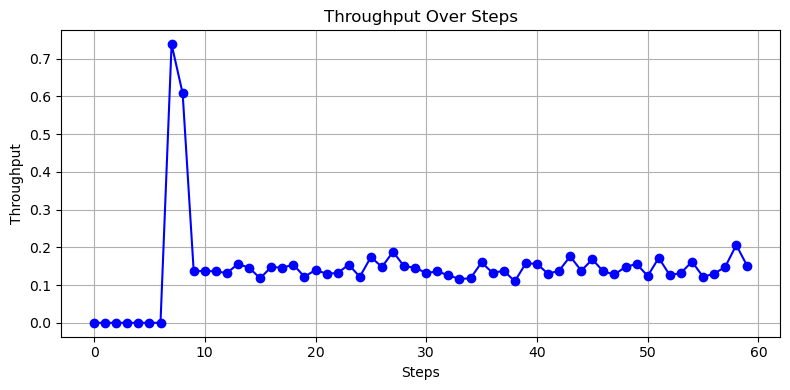

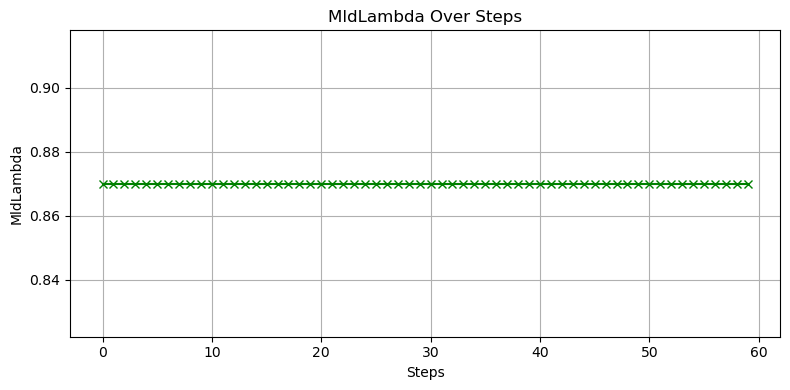

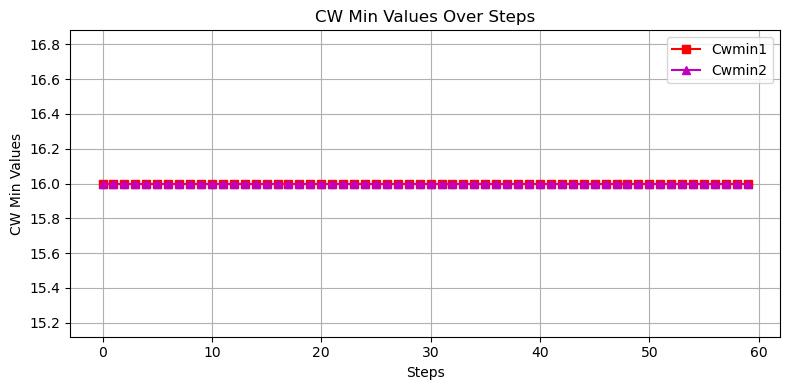

TOTAL THROUGHPUT: 8.634



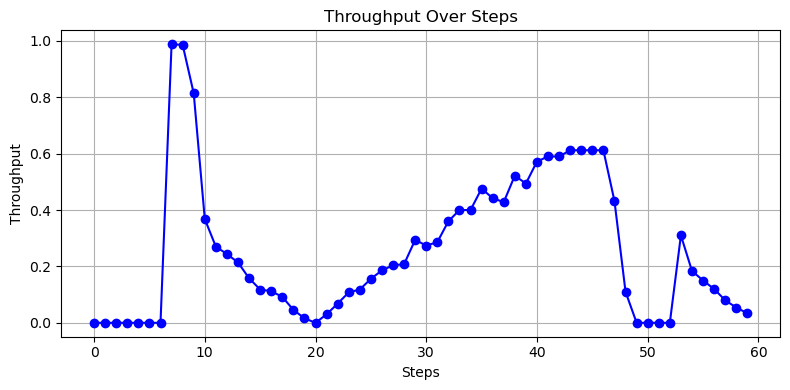

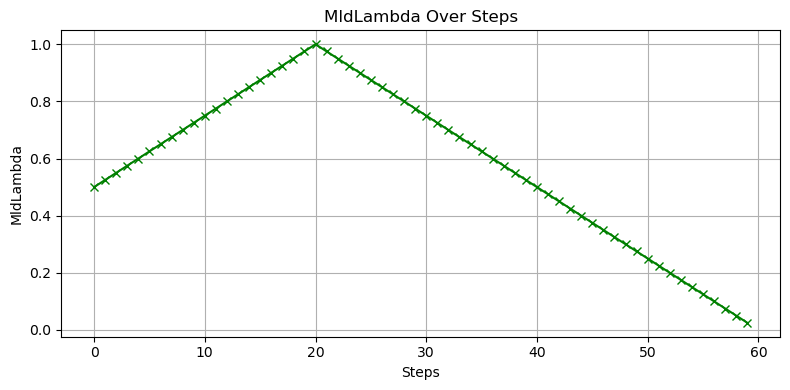

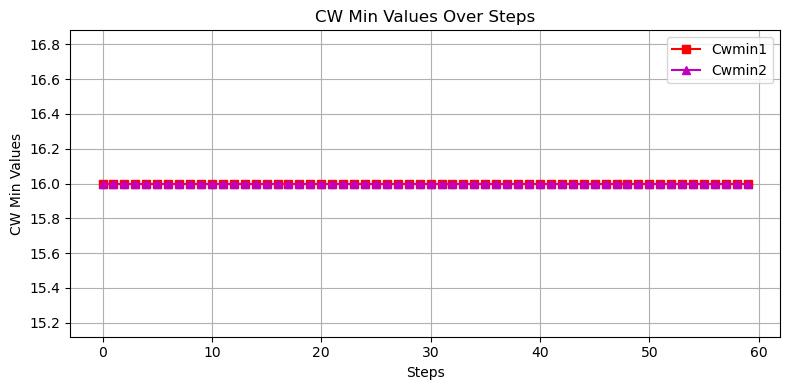

TOTAL THROUGHPUT: 15.554



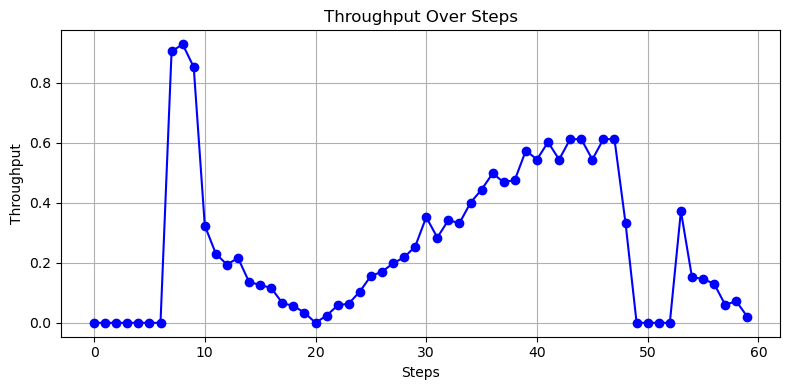

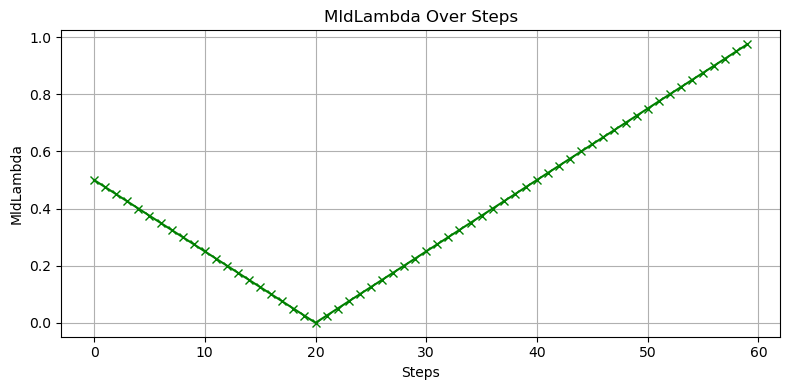

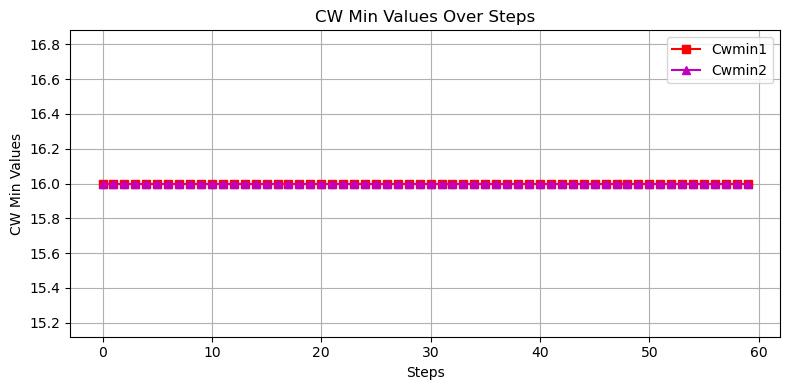

TOTAL THROUGHPUT: 15.564
ns3ai_utils: Killing subprocesses....
ns3ai_utils: Experiment destroyed


In [8]:
!rm /dev/shm/*
np.random.seed(25)

def run_ai3():
    env=Environnment(step_size=0.1,max_steps=60, mldPerNodeLambda=0.1)

    for loop in np.arange(3):


        throughput=[]
        mldlambda=[]
        cwmin1=[]
        cwmin2=[]

        done = False
        moves=0
        for i in np.arange(60):
            state = env.get_state()
            state_c = dton(state)
            env.step()
            

            np.set_printoptions(formatter={'all': lambda x: f' {x}'},suppress=True)

            if i>=env.max_steps:
                done=True
            

            throughput.append(state_c[0])
            mldlambda.append(state_c[3])

            cwmin1.append(state_c[1])
            cwmin2.append(state_c[2])

        
        print("", flush=True)


        steps = range(len(throughput))  # This assumes all lists are of the same length

        # Plot throughput on its own figure
        plt.figure(figsize=(8, 4))
        plt.plot(steps, throughput, label="Throughput", color='b', linestyle='-', marker='o')
        plt.xlabel('Steps')
        plt.ylabel('Throughput')
        plt.title('Throughput Over Steps')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot mldlambda on its own figure
        plt.figure(figsize=(8, 4))
        plt.plot(steps, mldlambda, label="MldLambda", color='g', linestyle='-', marker='x')
        plt.xlabel('Steps')
        plt.ylabel('MldLambda')
        plt.title('MldLambda Over Steps')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot cwmin1 and cwmin2 on the same figure
        plt.figure(figsize=(8, 4))
        plt.plot(steps, cwmin1, label="Cwmin1", color='r', linestyle='-', marker='s')
        plt.plot(steps, cwmin2, label="Cwmin2", color='m', linestyle='-', marker='^')
        plt.xlabel('Steps')
        plt.ylabel('CW Min Values')
        plt.title('CW Min Values Over Steps')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f'TOTAL THROUGHPUT: {np.sum(np.array(throughput))}')

        env.reset()


process = Process(target=run_ai3)
process.start()
process.join()

In [9]:
# !rm /dev/shm/*
# def run_experiment(loop_id):

#     unique_id = str(uuid.uuid4())
#     print(f"Starting loop {loop_id}, PID: {os.getpid()}")

#     filepath = '/mnt/c/Users/BarbarianMatt/Code/Python/EE595ProjectAI/ns-3-dev'

#     setting = { "num_env": 1, 
#                 "m_segmentName":f"My_Seg_{unique_id}",
#                 "m_cpp2pyMsgName":f"My_Cpp_to_Python_Msg_{unique_id}",
#                 "m_py2cppMsgName":f"My_Python_to_Cpp_Msg_{unique_id}",
#                 "m_lockableName":f"My_Lockable_{unique_id}"
#                 }

#     exp = Experiment(
#         "ns3ai_apb_msg_stru",
#         filepath,
#         py_binding,
#         handleFinish=True,
#         segName=setting['m_segmentName'],
#         cpp2pyMsgName=setting['m_cpp2pyMsgName'],
#         py2cppMsgName=setting['m_py2cppMsgName'],
#         lockableName=setting['m_lockableName']
#     )

#     result = subprocess.run(['ls', '/dev/shm'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

#     # Print the output (list of shared memory segments)
#     if result.returncode == 0:
#         print("Shared memory segments:")
#         print(result.stdout)
#     else:
#         print(f"Error: {result.stderr}")

#     print("Starting experiment...", flush=True)
#     msgInterface = exp.run(setting=setting, show_output=True)
#     print("Experiment started.", flush=True)

#     end = False
#     for j in np.arange(10):
#         done = False
#         for i in np.arange(20):
#             if i == 19:
#                 done = True
#             if done and j == 9:
#                 end = True
            
#             msgInterface.PySendBegin()
#             temp =msgInterface.GetPy2CppStruct()
            
#             temp.done_simulation = done
#             temp.end_experiment = end
#             msgInterface.PySendEnd()

#             msgInterface.PyRecvBegin()
#             settings = msgInterface.GetCpp2PyStruct()
#             msgInterface.PyRecvEnd()

# for j in range(1):
#     process = Process(target=run_experiment, args=(j,))
#     process.start()
#     process.join()